In [1]:
import torch
import argparse
import random
import numpy as np
import pandas as pd
from src.graph_func import graph_construction
from src.utils_func import mk_dir, adata_preprocess, load_ST_file, res_search_fixed_clus, plot_clustering
from src.training import conST_training

import anndata
from sklearn import metrics
import matplotlib.pyplot as plt
import scanpy as sc
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--k', type=int, default=10, help='parameter k in spatial graph')
parser.add_argument('--knn_distanceType', type=str, default='euclidean',
                    help='graph distance type: euclidean/cosine/correlation')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--cell_feat_dim', type=int, default=300, help='Dim of PCA')
parser.add_argument('--feat_hidden1', type=int, default=100, help='Dim of DNN hidden 1-layer.')
parser.add_argument('--feat_hidden2', type=int, default=20, help='Dim of DNN hidden 2-layer.')
parser.add_argument('--gcn_hidden1', type=int, default=32, help='Dim of GCN hidden 1-layer.')
parser.add_argument('--gcn_hidden2', type=int, default=8, help='Dim of GCN hidden 2-layer.')
parser.add_argument('--p_drop', type=float, default=0.2, help='Dropout rate.')
parser.add_argument('--use_img', type=bool, default=False, help='Use histology images.')
parser.add_argument('--img_w', type=float, default=0.1, help='Weight of image features.')
parser.add_argument('--use_pretrained', type=bool, default=True, help='Use pretrained weights.')
parser.add_argument('--using_mask', type=bool, default=False, help='Using mask for multi-dataset.')
parser.add_argument('--feat_w', type=float, default=10, help='Weight of DNN loss.')
parser.add_argument('--gcn_w', type=float, default=0.1, help='Weight of GCN loss.')
parser.add_argument('--dec_kl_w', type=float, default=10, help='Weight of DEC loss.')
parser.add_argument('--gcn_lr', type=float, default=0.01, help='Initial GNN learning rate.')
parser.add_argument('--gcn_decay', type=float, default=0.01, help='Initial decay rate.')
parser.add_argument('--dec_cluster_n', type=int, default=10, help='DEC cluster number.')
parser.add_argument('--dec_interval', type=int, default=20, help='DEC interval nnumber.')
parser.add_argument('--dec_tol', type=float, default=0.00, help='DEC tol.')

parser.add_argument('--seed', type=int, default=0, help='random seed')
parser.add_argument('--beta', type=float, default=100, help='beta value for l2c')
parser.add_argument('--cont_l2l', type=float, default=0.3, help='Weight of local contrastive learning loss.')
parser.add_argument('--cont_l2c', type=float, default= 0.1, help='Weight of context contrastive learning loss.')
parser.add_argument('--cont_l2g', type=float, default= 0.1, help='Weight of global contrastive learning loss.')

parser.add_argument('--edge_drop_p1', type=float, default=0.1, help='drop rate of adjacent matrix of the first view')
parser.add_argument('--edge_drop_p2', type=float, default=0.1, help='drop rate of adjacent matrix of the second view')
parser.add_argument('--node_drop_p1', type=float, default=0.2, help='drop rate of node features of the first view')
parser.add_argument('--node_drop_p2', type=float, default=0.3, help='drop rate of node features of the second view')

# ______________ Eval clustering Setting ______________
parser.add_argument('--eval_resolution', type=int, default=1, help='Eval cluster number.')
parser.add_argument('--eval_graph_n', type=int, default=20, help='Eval graph kN tol.') 

params =  parser.parse_args(args=['--k', '20', '--knn_distanceType', 'euclidean', '--epochs', '200'])

np.random.seed(params.seed)
torch.manual_seed(params.seed)
torch.cuda.manual_seed(params.seed)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using device: ' + device)
params.device = device

# set seed before every run
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch(params.seed)

Using device: cuda:0


In [5]:
save_root = '/home/lytq/Spatial-Transcriptomics-Benchmark/Results/results3/Mouse_Olfactory_Bulb/conST'
data_root = '/home/lytq/Spatial-Transcriptomics-Benchmark/data/Mouse_Olfactory_Bulb'

params.save_path = mk_dir(save_root)

In [6]:
counts_file = os.path.join(data_root, 'RNA_counts.tsv.gz')
coor_file = os.path.join(data_root, 'position.tsv')

counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')

counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

adata = sc.read_h5ad(os.path.join(data_root, 'raw.h5ad'))
adata.var_names_make_unique()

coords = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obs['x'] = coords['x']
adata.obs['y'] = coords['y']
adata.obsm['spatial'] = coords.to_numpy()

used_barcode = pd.read_csv(os.path.join(data_root, 'used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]
adata

(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

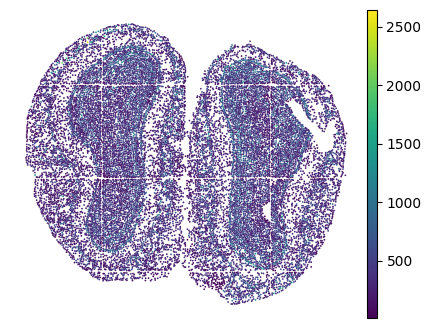

In [7]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [8]:
adata

AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

In [9]:
n_clusters = 7

adata_h5 = adata.copy()
adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
params.cell_num = adata_h5.shape[0]

if params.use_img:
    img_transformed = np.load('./MAE-pytorch/extracted_feature.npy')
    img_transformed = (img_transformed - img_transformed.mean()) / img_transformed.std() * adata_X.std() + adata_X.mean()
    conST_net = conST_training(adata_X, graph_dict, params, n_clusters, img_transformed)
else:
    conST_net = conST_training(adata_X, graph_dict, params, n_clusters)


conST_net.pretraining()
conST_net.major_training()

conST_embedding = conST_net.get_embedding()

===== Preprocessing Data 


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 65.6245
Major training stage:  |################| 200 / 200 | Loss: 3.8876


In [11]:
adata_h5

AnnData object with n_obs × n_vars = 19109 × 22777
    obs: 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

In [12]:
adata_conST = anndata.AnnData(conST_embedding, obs=adata_h5.obs)
# adata_conST.uns['spatial'] = adata_h5.uns['spatial']
adata_conST.obsm['spatial'] = adata_h5.obsm['spatial']

sc.pp.neighbors(adata_conST, n_neighbors=params.eval_graph_n)

eval_resolution = res_search_fixed_clus(adata_conST, n_clusters)
print(eval_resolution)
cluster_key = "conST_leiden"
sc.tl.leiden(adata_conST, key_added=cluster_key, resolution=eval_resolution)

0.3600000000000001


In [16]:
adata_conST.obs

,x,y,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,leiden,conST_leiden
Spot_1,12555.007833,6307.537859,428,6.061457,490.842621,6.198159,21.799251,33.176138,53.549266,100.000006,1,1
Spot_10,12806.715054,6311.983871,209,5.347108,240.722229,5.487789,33.948764,54.719595,96.261251,100.000000,1,1
Spot_100,12752.469565,6425.617391,153,5.036953,189.000000,5.247024,45.502646,71.957672,100.000000,100.000000,1,1
Spot_1000,12545.601942,6856.786408,177,5.181784,212.833328,5.365197,40.328892,63.821451,99.999993,99.999993,0,0
Spot_10000,12993.429134,9153.204724,332,5.808142,386.515137,5.959755,27.040377,39.976481,65.848689,100.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
Spot_9994,14127.819588,9148.005155,275,5.620401,325.076904,5.787133,30.785614,46.166589,76.928541,100.000000,0,0
Spot_9995,12933.872611,9147.484076,208,5.342334,261.500000,5.570251,39.579350,58.699809,96.940727,100.000000,1,1
Spot_9996,13328.963303,9155.389908,334,5.814131,388.083313,5.963793,26.733950,39.703677,65.471340,100.000008,1,1
Spot_9998,12637.854167,9150.281250,122,4.812184,136.833344,4.926045,47.381240,83.922046,100.000000,100.000000,1,1


In [18]:
adata_conST.obs['label_shift'] = (adata_conST.obs['conST_leiden'].astype(int) + 1).astype('category')

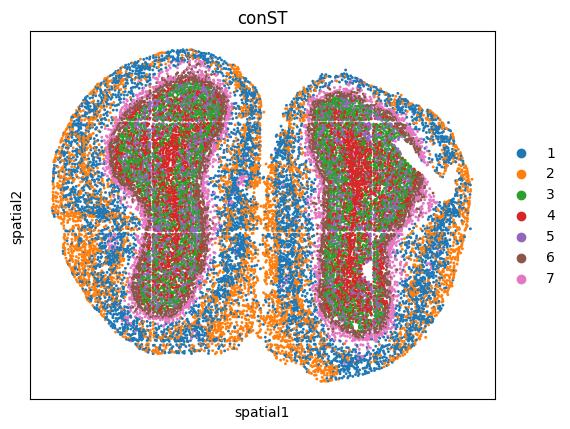

In [19]:
# plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.spatial(adata_conST, color="label_shift", show=False, title='conST', ax=ax, spot_size=40)
ax.invert_yaxis()
# plt.axis('off')
plt.savefig(os.path.join(save_root, 'clustering.pdf'), dpi=300, bbox_inches='tight')

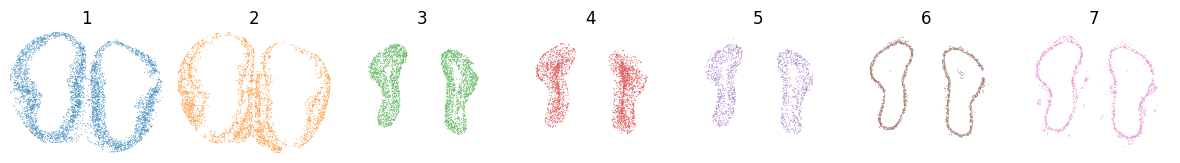

In [30]:
fig, axes = plt.subplots(1,n_clusters,figsize=(1.7*n_clusters, 1.5*2), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(n_clusters):
    sub = adata_conST[adata_conST.obs['label_shift'] == i+1]
    sc.pl.spatial(sub, spot_size=30, color='conST_leiden', ax=axes[i], legend_loc=None, show=False)
    axes[i].set_title(i+1)


xmin = adata_conST.obsm['spatial'][:, 0].min()
xmax = adata_conST.obsm['spatial'][:, 0].max()
ymin = adata_conST.obsm['spatial'][:, 1].min()
ymax = adata_conST.obsm['spatial'][:, 1].max()

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()
plt.savefig(os.path.join(save_root, f'each_cluster.pdf'), dpi=300, bbox_inches='tight')

In [31]:
cell_metadata = adata.obs
cell_metadata

,x,y,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
Spot_1,12555.007833,6307.537859,428,6.061457,490.842621,6.198159,21.799251,33.176138,53.549266,100.000006
Spot_10,12806.715054,6311.983871,209,5.347108,240.722229,5.487789,33.948764,54.719595,96.261251,100.000000
Spot_100,12752.469565,6425.617391,153,5.036953,189.000000,5.247024,45.502646,71.957672,100.000000,100.000000
Spot_1000,12545.601942,6856.786408,177,5.181784,212.833328,5.365197,40.328892,63.821451,99.999993,99.999993
Spot_10000,12993.429134,9153.204724,332,5.808142,386.515137,5.959755,27.040377,39.976481,65.848689,100.000000
...,...,...,...,...,...,...,...,...,...,...
Spot_9994,14127.819588,9148.005155,275,5.620401,325.076904,5.787133,30.785614,46.166589,76.928541,100.000000
Spot_9995,12933.872611,9147.484076,208,5.342334,261.500000,5.570251,39.579350,58.699809,96.940727,100.000000
Spot_9996,13328.963303,9155.389908,334,5.814131,388.083313,5.963793,26.733950,39.703677,65.471340,100.000008
Spot_9998,12637.854167,9150.281250,122,4.812184,136.833344,4.926045,47.381240,83.922046,100.000000,100.000000


In [32]:
cell_metadata.to_csv(os.path.join(save_root, 'cell_metadata.csv'))